# Decision trees and random forests for regression

Just imports

In [21]:
%matplotlib inline 

import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error


from plot_utils import visualize_tree, grid_plot


# Step example

First, we generate some (noisy) data on which to do regression.

In [22]:
np.random.seed(504)

In [23]:
X = np.linspace(0,30,100)

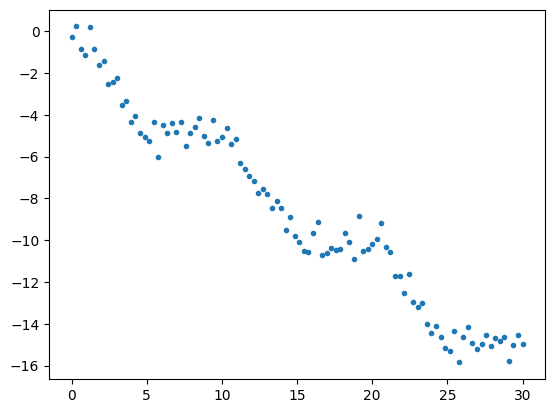

In [24]:
from math import floor

def sloped_step(x):
    section = floor(x / 10)
    x_relative = x - 10 * section
    baseline = section * -5
    if x_relative < 5:
        return baseline - x_relative
    else:
        return baseline - 5

y_easy = np.array([sloped_step(x) for x in X] + np.random.normal(0,.5,100)).ravel()

plt.plot(X, y_easy,'.')


In [25]:
from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor()
tree.fit(X.reshape(-1, 1), y_easy.ravel())

tree.get_depth()

13

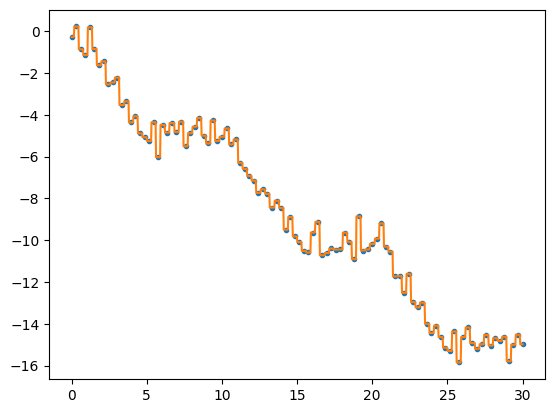

In [26]:
X_plot = np.linspace(0,30,1000).reshape(-1, 1)

plt.plot(X, y_easy, '.')
plt.plot(X_plot, tree.predict(X_plot), '-')


Clearly overfits.

Let's try some hyperparameters.

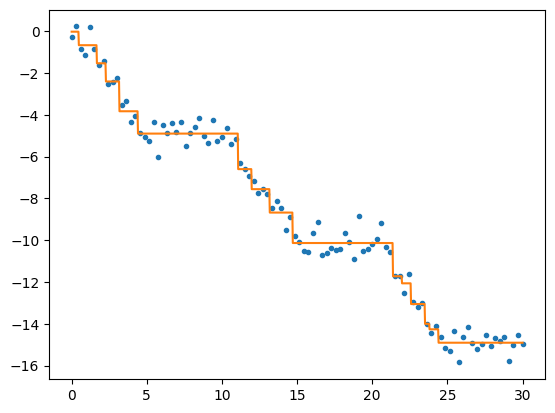

In [27]:
tree = DecisionTreeRegressor(max_depth = 4)
tree.fit(X.reshape(-1, 1), y_easy.ravel())

plt.plot(X, y_easy, '.')
plt.plot(X_plot, tree.predict(X_plot), '-')

Seems okay. Let's look at the tree.

In [ ]:
visualize_tree(tree, ["X"], None)

# Random Forest Regression
Let's try something more curvy

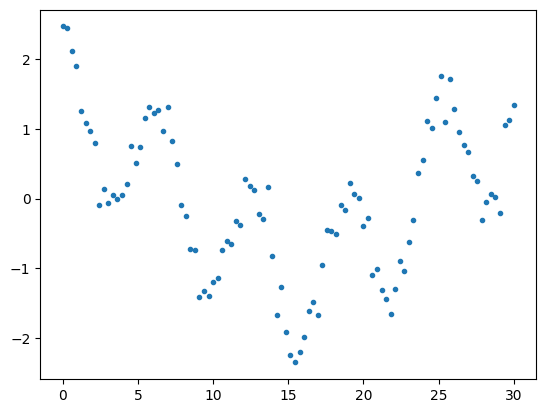

In [29]:
y = np.array(np.cos(X) + 1.2 * np.cos(X * .2) + np.random.normal(0,.2,100))

plt.plot(X, y,'.')

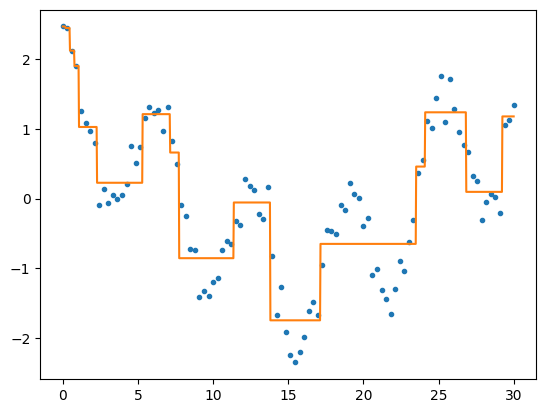

In [30]:
tree = DecisionTreeRegressor(max_depth = 4)
tree.fit(X.reshape(-1, 1), y.ravel())

plt.plot(X, y, '.')
plt.plot(X_plot, tree.predict(X_plot), '-')

Here, we train and plot a sequence of gradient boosted trees, using between 1 and 15 trees. Notice how using one tree severely underfits the data, while using too many trees lead to overfitting. Somewhere in between, we have a decent model.

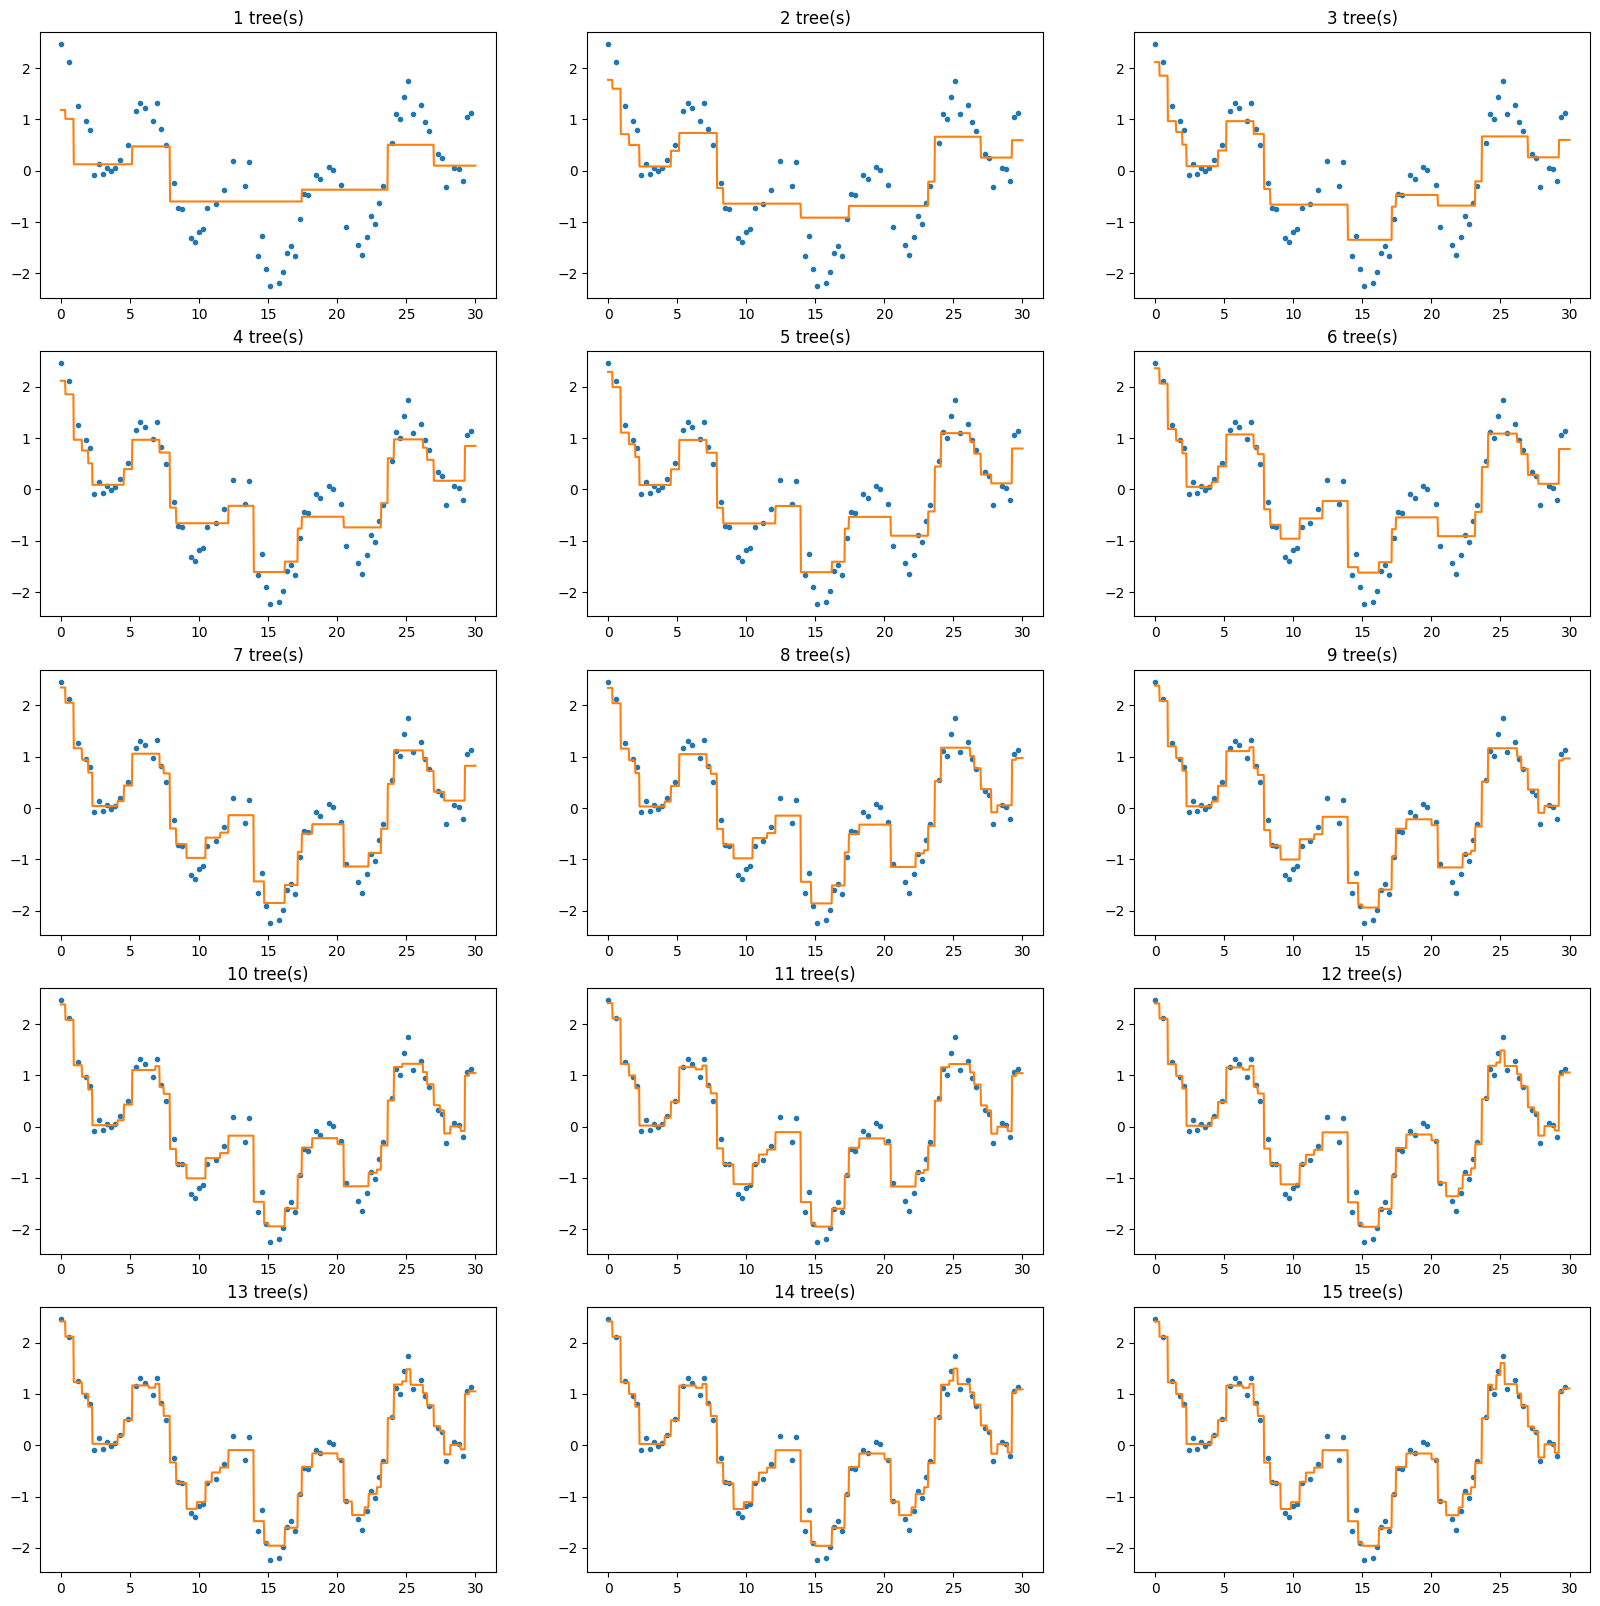

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X.reshape(-1, 1), y)

trees = [GradientBoostingRegressor(n_estimators=i+1, max_depth=3, learning_rate=0.5) for i in range(15)]

train_error, test_error = [], []

for tree in trees: 
    tree.fit(X_train, y_train)
    train_error.append(mean_squared_error(y_true=y_train, y_pred=tree.predict(X_train)))
    test_error.append(mean_squared_error(y_true=y_test, y_pred=tree.predict(X_test)))

def plot(ax, tree, index):
    ax.set_title("{} tree(s)".format(index + 1))
    ax.plot(X_train,y_train,'.')
    ax.plot(X_plot,tree.predict(X_plot),'-') #plot the actual predicted values

axes = grid_plot(trees, 3, 5, plot)


The way in which the algorithm works is by fitting tree n+1 to the _residuals_ of tree n, and then we add this "residual-tree" to the previous tree. Here, we plot the residuals and the "residual trees".

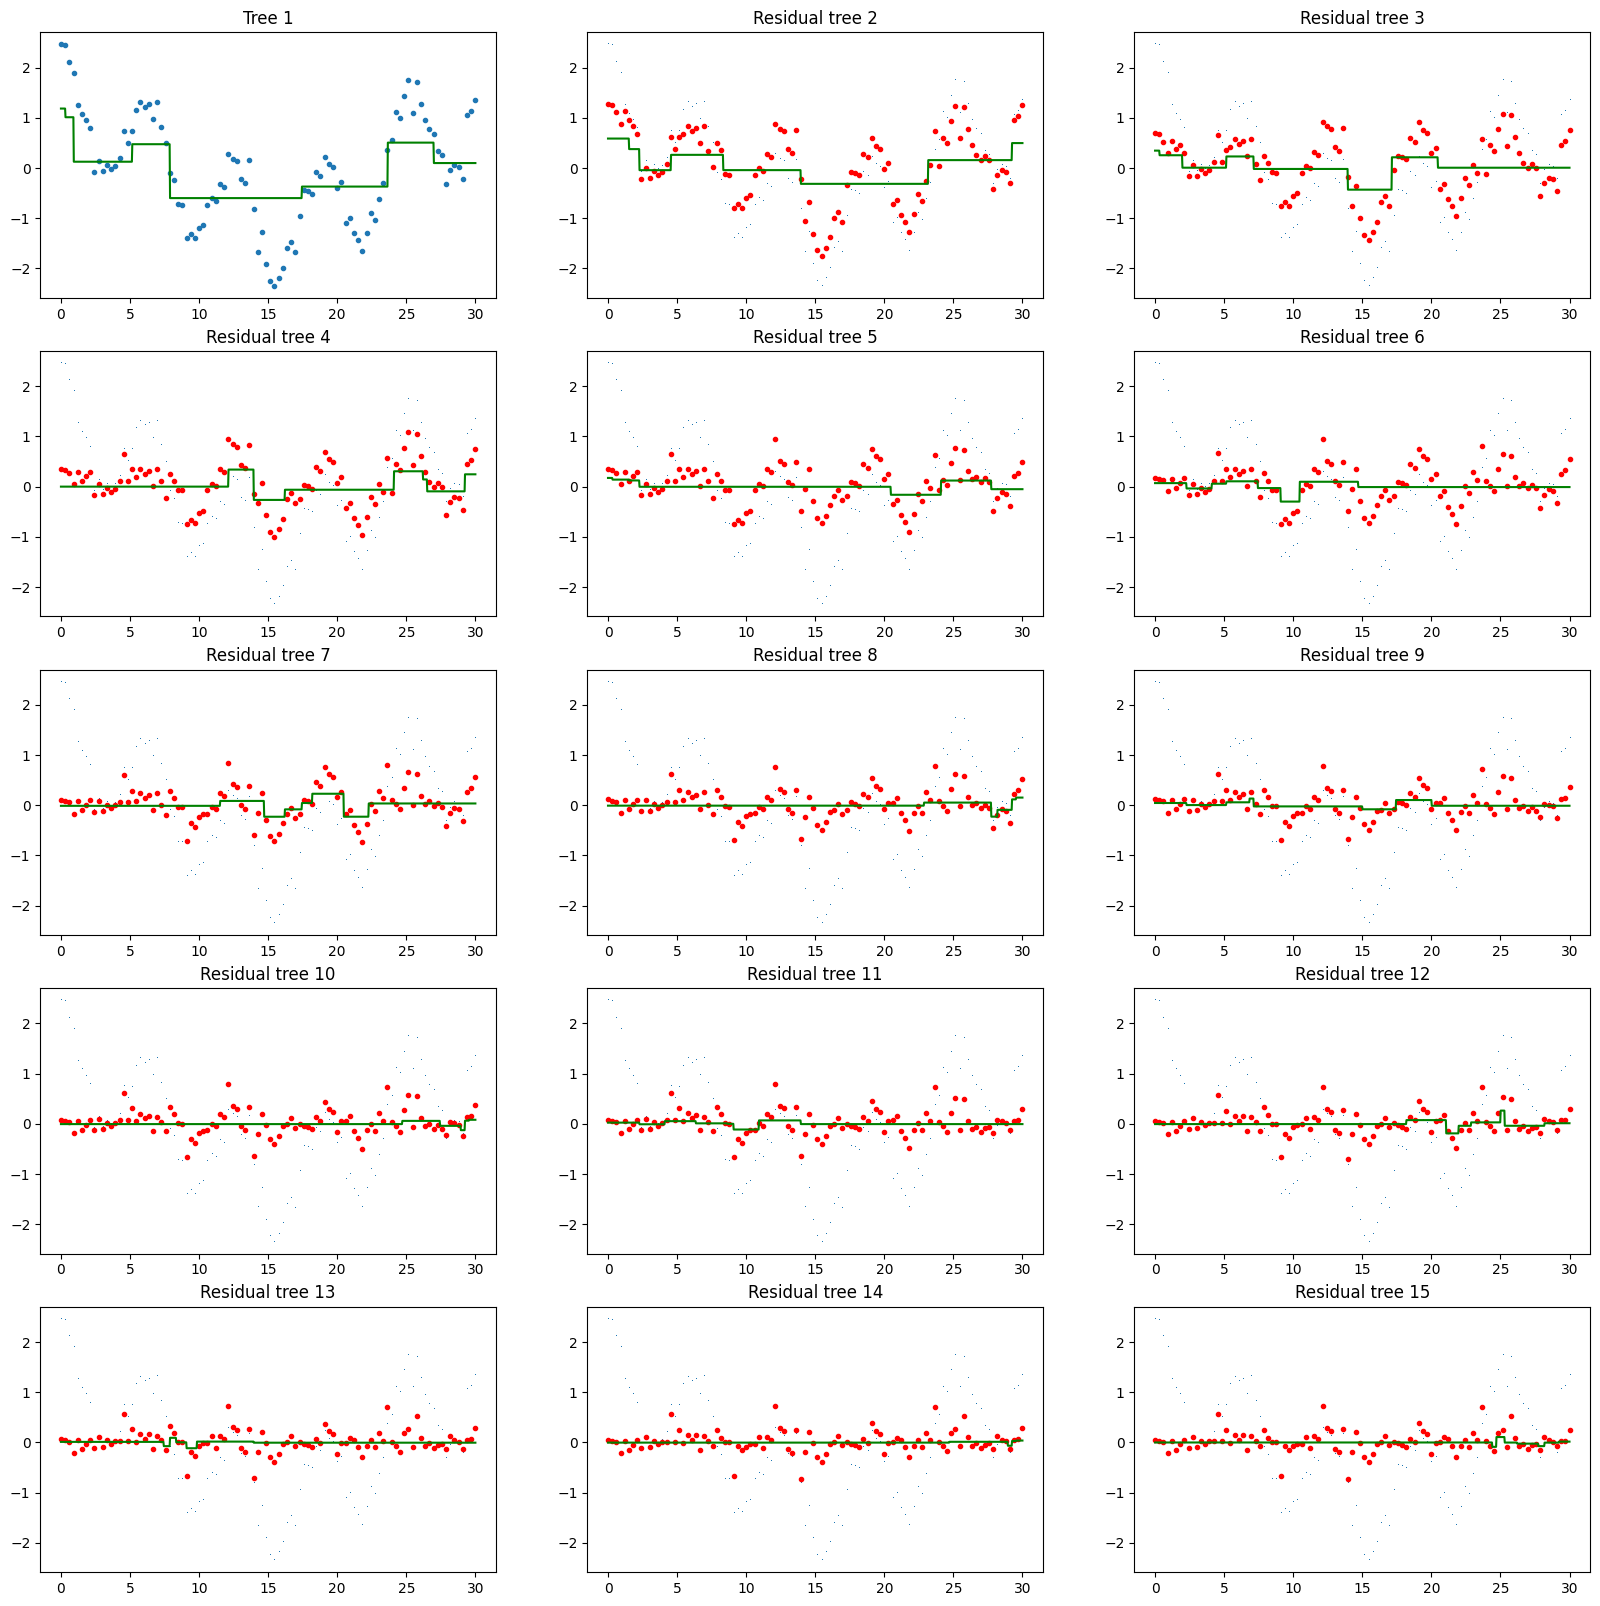

In [33]:
def plot_res(ax, tree, index):
    if index == 0:
        ax.plot(X, y, '.')
        ax.plot(X_plot, tree.predict(X_plot), 'g-')
        ax.set_title("Tree {}".format(index + 1))
    else:
        previous = trees[index - 1]
        ax.plot(X, y, ',')
        ax.plot(X, y - previous.predict(X.reshape(-1, 1)), 'r.')
        ax.plot(X_plot, tree.predict(X_plot) - previous.predict(X_plot),'g-')
        ax.set_title('Residual tree {}'.format(index+1))

axes = grid_plot(trees, 3, 5, plot_res)


Plot train and test error as a function of the number of trees.

In [ ]:
n_trees = range(1,len(trees)+1)
plt.plot(n_trees,train_error,'-', label = "Train error")
plt.plot(n_trees,test_error,'-', label = "Test error")
plt.xlabel("Number of trees")
plt.ylabel("Mean square error")
plt.legend()